In [1]:
import sys
sys.path.insert(0, "/home/pidoux/MASTER/ML/projet/Projet/Module")

from Loss import *
from Linear import *
from Activation import *
from Sequential import *
from Convolution import *
from mltools import *

import matplotlib.pyplot as plt
import random
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.datasets import fashion_mnist

def onehot(x):
    out = [0] * 10
    out[x] = 1
    return out


2023-05-02 08:37:56.736997: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-02 08:37:57.143585: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-02 08:37:57.144668: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 08:37:59.005956: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import numpy as np 
class Module(object):
    def __init__(self):
        self._parameters = None
        self._gradient = None

    def zero_grad(self):
        # Annule gradient
        pass

    def forward(self, X):
        # Calcule la passe forward
        pass

    def update_parameters(self, gradient_step=1e-3):
        # Calcule la mise a jour des parametres selon le gradient calculé et le pas de gradient_step
        self._parameters -= gradient_step * self._gradient

    def backward_update_gradient(self, input, delta):
        ## Met a jour la valeur du gradient
        pass

    def backward_delta(self, input, delta):
        ## Calcul la derivee de l'erreur
        pass 
    
class Conv1D(Module):
    def __init__(self, k_size, chan_in, chan_out, stride):
        self._k_size = k_size
        self._chan_in = chan_in
        self._chan_out = chan_out
        self._stride = stride
        #std = 1. / np.sqrt(k_size * chan_in)
        #self._parameters = np.random.normal(0, std, (k_size, chan_in, chan_out))
        self._parameters = np.random.randn(k_size, chan_in, chan_out) * np.sqrt(2. / (k_size * chan_in))
        self._bias = np.zeros((1, chan_out))
        self._gradient = np.zeros((k_size, chan_in, chan_out))
        self._bias_gradient = np.zeros((1, chan_out))

    def forward(self, X):
        X = X.reshape(X.shape[0],X.shape[1],-1)
        taille_img = np.size(X[0])//self._chan_in
        nb_img = np.size(X, axis=0)
        d_out = int((taille_img - self._k_size + 1) / self._stride)
        maxi = taille_img - self._k_size + 1
        output = np.zeros((nb_img, d_out, self._chan_out))

        for img in range(nb_img):
            for canal in range(self._chan_out):
                pas = -self._stride
                localisation = 0
                while pas + self._stride < maxi:
                    output[img, localisation, canal] = (
                        np.sum(self._parameters[:, :, canal] * X[img][pas + self._stride:pas + self._stride + self._k_size]) + self._bias[0, canal])
                    pas += self._stride
                    localisation += 1
        self._cache = (X, output)
        return output

    def backward_delta(self,X, delta):
        _, output = self._cache
        X = X.reshape(X.shape[0],X.shape[1],-1)
        nb_img, d_out, chan_out = output.shape

        # Mise à jour des gradients des paramètres, du biais et du gradient d'entrée
        #self._gradient = np.zeros((self._k_size, self._chan_in, chan_out))
        #self._bias_gradient = np.zeros((1, chan_out))
        delta_in = np.zeros_like(X)
        for img in range(nb_img):
            for i in range(d_out):
                for j in range(chan_out):
                    # Mise à jour du gradient des paramètres
                    self._gradient[:, :, j] += delta[img, i, j] * X[img, i * self._stride:i * self._stride + self._k_size, :]

                    # Mise à jour du gradient du biais
                    self._bias_gradient[0, j] += delta[img, i, j]

                    # Mise à jour du gradient d'entrée
                    delta_in[img, i * self._stride:i * self._stride + self._k_size, :] += delta[img, i, j] * self._parameters[:, :, j]
                    
        
        self._gradient /= nb_img
        self._bias_gradient /= nb_img
        delta_in /= nb_img
        
        return delta_in
    
    def backward_update_gradient(self, input, delta):
        ## Met a jour la valeur du gradient
        pass

    def update_parameters(self, gradient_step=1e-3):
        self._parameters -= gradient_step * self._gradient
        self._bias -= gradient_step * self._bias_gradient

    def zero_grad(self):
        self._gradient = np.zeros_like(self._parameters)
        self._bias_gradient = np.zeros_like(self._bias)


class MaxPool1D(Module):
    def __init__(self, pool_size, stride):
        self._pool_size = pool_size
        self._stride = stride
        self._cache = None

    def forward(self, X):
        X = X.reshape(X.shape[0], X.shape[1], -1)
        taille_img = np.size(X[0])//X.shape[2]
        nb_img = np.size(X, axis=0)
        d_out = int((taille_img - self._pool_size) / self._stride + 1)
        maxi = taille_img - self._pool_size + 1
        output = np.zeros((nb_img, d_out, X.shape[2]))

        for img in range(nb_img):
            for canal in range(X.shape[2]):
                pas = -self._stride
                localisation = 0
                while pas + self._stride < maxi:
                    window = X[img][pas + self._stride:pas + self._stride + self._pool_size, canal]
                    output[img, localisation, canal] = np.amax(window)
                    pas += self._stride
                    localisation += 1

        self._cache = (X, output)
        return output

    def backward_delta(self, X, delta):
        _, output = self._cache
        X = X.reshape(X.shape[0], X.shape[1], -1)
        delta_in = np.zeros_like(X)
        nb_img, d_out, chan_out = output.shape
        

        for img in range(nb_img):
            for i in range(d_out):
                for j in range(chan_out):
                    window = X[img][i * self._stride:i * self._stride + self._pool_size, j]
                    max_idx = np.argmax(window)
                    max_coord = np.unravel_index(max_idx, window.shape)
                    delta_in[img, i * self._stride + max_coord[0], j] += delta[img, i, j]

        return delta_in

    def zero_grad(self):
        pass

    def update_parameters(self, gradient_step=1e-3):
        pass


class flatten(Module):
    def __init__(self):
        self._input_shape = None

    def forward(self, X):
        self._input_shape = X.shape
        return X.reshape(X.shape[0], -1)

    def backward_delta(self, X, delta):
        return delta.reshape(self._input_shape)
    
    
    def update_parameters(self, gradient_step=0.001):
        """
        Pas de mise à jour des parametres
        """
        pass

    def backward_update_gradient(self, input, delta):
        """
        Pas de gradients des paramètres ni du biais
        """
        pass

class Relu(Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        # Calcule la passe forward
        return np.maximum(0, input)

    def backward_delta(self, input, delta):
        # Calcul la dérivée de l'erreur
        relu_grad = (input > 0).astype(float)
        return delta * relu_grad
    
    def update_parameters(self, gradient_step=0.001):
        """
        Pas de mise à jour des parametres
        """
        pass

    def backward_update_gradient(self, input, delta):
        """
        Pas de gradients des paramètres ni du biais
        """
        pass


100%|██████████| 200/200 [1:29:08<00:00, 26.74s/it]


[6 5 4 7 3 6 3 1 0 1 7 0 1 1 7 7 4 8 0 1 4 8 7 4 8 7 3 7 4 1 3 6 7 4 1 3 7
 7 4 6 4 2 7 4 1 3 7 7 4 0 6 3 2 2 8 6 6 2 0 8 7 8 2 0 9 0 2 2 0 8 1 2 0 8
 3 3 2 8 2 2 0 8 1 4 4 8 9 8 4 6 7 6 1 9 7 0 8 0 4 6]
[6 5 4 7 3 6 3 1 0 1 7 0 1 1 7 7 4 8 0 1 4 8 7 4 8 7 3 7 4 1 3 6 7 4 1 3 7
 7 4 5 4 2 7 4 1 3 7 7 4 0 6 3 2 0 8 6 6 2 0 8 7 8 2 0 9 0 2 2 0 8 1 2 0 8
 3 3 2 8 2 2 0 8 1 4 4 8 9 8 9 6 7 6 1 9 7 0 8 0 4 6]
0.97


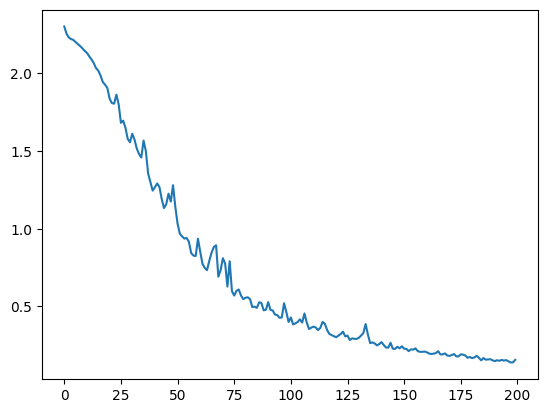

In [4]:
def load_usps(fn):
    with open(fn,"r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp=np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

def get_usps(l,datax,datay):
    if type(l)!=list:
        resx = datax[datay==l,:]
        resy = datay[datay==l]
        return resx,resy
    tmp =   list(zip(*[get_usps(i,datax,datay) for i in l]))
    tmpx,tmpy = np.vstack(tmp[0]),np.hstack(tmp[1])
    return tmpx,tmpy

def show_usps(data):
    plt.imshow(data.reshape((16,16)),interpolation="nearest",cmap="gray")
    plt.show()

uspsdatatrain = "data/USPS_train.txt"
uspsdatatest = "data/USPS_test.txt"
X_train,y_train = load_usps(uspsdatatrain)
X_test,y_test = load_usps(uspsdatatest)
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],-1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],-1))
X_train /= 255
X_test /= 255
X_train = X_train[:300]
y_train = y_train[:300]
X_test = X_test[70:100]
y_test = y_test[70:100]
y_train = np.asarray([onehot(x) for x in y_train])


k_size, chan_in, chan_out, stride = 3, 1, 32, 1

conv = Conv1D(k_size, chan_in, chan_out, stride)
maxpool = MaxPool1D(2, 2)
flat = flatten()
lin = Linear(4064, 100)
rel = Relu()
lin2 = Linear(100,10)
softmax = Softmax()
loss = CElogSMLoss()

epoch = 200
gradient_step = 1e-2
batchsize = 100


net = Sequential([conv,maxpool,flat,lin,rel,lin2])

opt = Optim(net,loss,eps=gradient_step)
L = opt.SGD(X_train,y_train,batchsize,epoch)
plt.plot(L)
pred = opt.predict(X_test,'soft')
print(pred)
print(y_test)
print(opt.accuracy(pred,y_test))

Accuracy 0.9


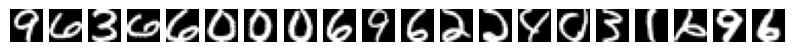

Prédiction [9 2 3 2 6 0 0 0 6 9 6 2 2 4 0 5 1 6 9 6]


In [29]:
pred = opt.predict(X_test,'soft')
def draw_pred(X_test,n=10):
    fig = plt.figure(figsize=(10,10))
    for i in range(n):
        ax = fig.add_subplot(1,n,i+1)
        ax.imshow(X_test[i].reshape(16,16),cmap='gray')
        ax.axis('off')
    plt.show()
print('Accuracy',opt.accuracy(pred,y_test))
draw_pred(X_test,n=20)
print('Prédiction',pred[:20])
#print('Réalité',y_test)

In [ ]:
print('Accuracy',opt.accuracy(pred,y_test))
draw_pred(X_test,n=20)
print('Prédiction',pred[:20])